In [1]:
import pandas as pd
from pathlib import Path

pd.set_option('display.width', 1000)

In [2]:
# online banking transaction data
path = Path('./data/Fraud Detection with Natural Language Processing.pkl')
df_data = pd.read_pickle(path)

In [3]:
# remove rows with invalid time values
df_data = df_data[df_data.times.apply(lambda x: x[-1]=="]")]

In [4]:
# print 1st 10 rows of data to get an idea what it looks like
print(df_data.head(10))

# use .shape to get row count
num_rows = df_data.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                              actions                                              times  execution_time  Amount  device_freq   ip_freq  beneficiary_freq  application_freq  is_fraud
1   [[22], [27], [24], [1], [1268], [1269], [1267]...  [0, 33204.0, 215636.0, 443415.0, 72586.0, 3424...             203      13     1.000000  1.000000          0.500000               1.0         0
2   [[22], [24], [27], [1], [1268], [1269], [1267]...  [0, 25459.0, 46236.0, 428626.0, 42785.0, 74158...             359     310     1.000000  0.333333          0.333333               1.0         0
3   [[22], [1], [29], [22], [26], [2], [23], [25],...  [0, 440927.0, 5785.0, 46875.0, 968650.0, 31175...             250     350     1.000000  0.500000          0.500000               1.0         0
4   [[22], [24], [27], [72], [1269], [1268], [1267...  [0, 93894.0, 46810.0, 548388.0, 132548.0, 3784...             203     350     1.000000  0.600000          0.400000               1.0         0
5   [[22],

In [5]:
# use built in .info() method to show column data types and non-null count
df_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 105302 entries, 1 to 105302
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   actions           105302 non-null  object 
 1   times             105302 non-null  object 
 2   execution_time    105302 non-null  int64  
 3   Amount            105302 non-null  int32  
 4   device_freq       105302 non-null  float64
 5   ip_freq           105302 non-null  float64
 6   beneficiary_freq  105302 non-null  float64
 7   application_freq  105302 non-null  float64
 8   is_fraud          105302 non-null  int64  
dtypes: float64(4), int32(1), int64(2), object(2)
memory usage: 7.6+ MB


In [6]:
with pd.option_context('display.float_format', '  {:.1f}'.format, 'display.width', 100):
    print(df_data.describe().T)

                      count    mean      std    min     25%     50%     75%         max
execution_time     105302.0   655.7   1367.9   15.0   359.0   623.0   795.0    127578.0
Amount             105302.0   468.8   7096.0    0.0    37.0   100.0   240.0   1500000.0
device_freq        105302.0     0.7      0.3    0.0     0.4     0.9     1.0         1.0
ip_freq            105302.0     0.3      0.3    0.0     0.0     0.1     0.3         1.0
beneficiary_freq   105302.0     0.4      0.3    0.0     0.1     0.3     0.6         1.0
application_freq   105302.0     0.9      0.2    0.0     0.9     1.0     1.0         1.0
is_fraud           105302.0     0.0      0.0    0.0     0.0     0.0     0.0         1.0


In [7]:
# show bin counts for 'is_fraud'
class_counts = df_data['is_fraud'].value_counts()
print(class_counts)

is_fraud
0    105201
1       101
Name: count, dtype: int64


In [8]:
# vocabulary of API calls
path_vocab = Path('./data/vocab.csv')
df_vocab = pd.read_csv(path_vocab)

In [9]:
# print 1st 10 rows of data to get an idea what it looks like
print(df_vocab.head(20))

# use .shape to get row count
num_rows = df_vocab.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                       Name
0          /ACCOUNTS/ACCOUNTS_FULL_EXCHANGE
1                      /PROFILE/USERPROFILE
2                /P2PREGISTRATION/ASKMEMBER
3                         /CARDS/FETCHCARDS
4                   /ACCOUNTS/ACCOUNTS_FULL
5                    /CAMPAIGN/GETCAMPAIGNS
6                           /TEMPLATES/META
7                 /TRANSACTIONS/SERIES/POST
8             /USERROLE/GETAPPLICATIONROLES
9                  /API/CAMPAIGN/GETBALANCE
10  /P2PMEMBER/GETP2PMEMBERIDBYACTUALUSERID
11                            /ACCOUNTS/GET
12                          /CATEGORIES/GET
13        /MASSPAYMENTS/DEFERREDMASSNOFILES
14                              /LOANS/LIST
15                          /WEALTH/PARTYID
16           /TIMEDEPOSITS/DETAILEDACCOUNTS
17                /AUTHENTICATION/FASTLOGIN
18           /API/FASTLOGIN/EXPIRATIONQUERY
19                           /ACCOUNT/LOGIN

Number of rows: 1916


In [10]:
#%pip install wordninja

In [11]:
import re
import wordninja

def transform_name(name):

    # change to lower case
    name = name[1:].lower()
    name = name.replace('userid',' user id ')
    name = name.replace('smsotp',' sms otp ')

    # replace '/' and '_' with spaces
    name = re.sub(r'[/]', ' and ', name)
    name = re.sub(r'[_]', ' ', name)
    
    # Split compound words using wordninja
    parts = wordninja.split(name)
    
    # Join the parts with a space and convert to lowercase
    name = ' '.join(parts).strip().lower()

    # fix some of the words split up by wordninja
    name = re.sub(r'\bv\b', 'version', name)
    name = re.sub(r'\bp\s2\sp\b', 'peer', name)
    name = re.sub(r'\bot\sp\b', 'otp', name)
    name = re.sub(r'\bp\s2\sb\b', 'business', name)
    name = re.sub(r'\bs\ssf\b', 'ssf', name)
    name = re.sub(r'\bp\sfm\b', 'pay from', name)
    name = re.sub(r'\bi\sban\staxi\sd\b', 'iban tax id', name)
    name = re.sub(r'\bi\sban\sbic\b', 'iban bic', name)
    
    # put payment abbreviation types back together
    match = re.search(r'api(.*?)payment', name)
    if match:
        match = re.sub(r'\s+', '', match.group(1).strip())
        name = f"api {match} payment"

    # Format the final string
    return f"{name} ."

In [12]:
# transform the vocabulary 
df_vocab['new_name'] = df_vocab['Name'].apply(transform_name)

# print 1st 10 rows of data to get an idea what it looks like
print(df_vocab.head(20))

# use .shape to get row count
num_rows = df_vocab.shape[0]
print(f"\nNumber of rows: {num_rows}")

                                       Name                                           new_name
0          /ACCOUNTS/ACCOUNTS_FULL_EXCHANGE              accounts and accounts full exchange .
1                      /PROFILE/USERPROFILE                         profile and user profile .
2                /P2PREGISTRATION/ASKMEMBER                 peer registration and ask member .
3                         /CARDS/FETCHCARDS                            cards and fetch cards .
4                   /ACCOUNTS/ACCOUNTS_FULL                       accounts and accounts full .
5                    /CAMPAIGN/GETCAMPAIGNS                       campaign and get campaigns .
6                           /TEMPLATES/META                               templates and meta .
7                 /TRANSACTIONS/SERIES/POST                 transactions and series and post .
8             /USERROLE/GETAPPLICATIONROLES              user role and get application roles .
9                  /API/CAMPAIGN/GETBALANCE       

In [13]:
# helper script to find short words and then fix
unique_short_words = set()
name_dict = {}

for index, row in df_vocab.iterrows():
    name = row['new_name']
    words = name.split()
    for word in words:
        if len(word) < 4:
            unique_short_words.add(word)
            if word not in name_dict:
                name_dict[word] = []
            name_dict[word].append(name)

print("Unique short words:", unique_short_words)
print("Original names by short word:")
for word, names in name_dict.items():
    print(f"{word}: {names}")

Unique short words: {'add', 'org', 'trn', 'tax', 'i', 'www', 'nt', 'no', 'os', 's', 'e', 'er', 'of', 'mk', 'pos', 'put', 'po', 'up', 't', 'log', 'cc', 'and', 'geo', 'de', 'te', 'ids', 'a', 'pro', 'rf', 'it', 'o', 'is', 'car', 'st', 'db', 'sue', 'gia', 'set', 'ui', 'mod', 'doc', 'vol', 'eu', '.', 'pay', 'eps', '3', 'row', 'can', 'get', 'if', 'un', 'ro', 'tho', 'api', 'ds', 'd', 'mer', 'net', 'isp', 'pre', 'aps', 'imp', 'dom', 'zip', 'erp', 'cp', '4', 'ask', 'ppl', 'fb', 'ib', 'xml', 'old', 'ent', 'gr', 'max', 'all', 'new', 'faq', 'ms', 'ex', '1', 'on', 'own', 'fp', 'buy', 'maz', 'mt', 'us', 'to', 'co', 'app', 'c', 'ott', 'pm', 'sco', 'top', 'nf', 'ext', 'atm', 'iv', 'id', 'rts', 'ban', 'pin', 'ka', 'ky', 'pp', 'mi', '2', 'not', 'p', 'or', 'hdi', 'gdp', 'pi', 'my', 'rib', 'r', 'gp', 'bic', 'b', '0', 'ssf', 'fid', 'by', 'ep', 'pdf', 'web', 'sms', 'in', 'otp', 'for', 'ard'}
Original names by short word:
and: ['accounts and accounts full exchange .', 'profile and user profile .', 'peer regi

In [14]:
#build the raw text, using the names and the (index-inverted) tokens 
action_names = df_vocab.new_name.to_list()
id_to_action = {str(i):a for i,a in enumerate(action_names)}
action_to_id = {a:str(i) for i,a in enumerate(action_names)}

In [15]:
import numpy as np
from ast import literal_eval

df = df_data.copy(deep=True)

# Recall to cast the strings into lists
df.actions = df.actions.apply(literal_eval)

df["times"] = df.times.apply(literal_eval).apply(lambda x: [i/1000 for i in x])
df["Action time mean"] = df.times.apply(np.mean)
df["Action time std"] = df.times.apply(np.std)
df["log(amount)"] = df.Amount.apply(np.log)
df["Transaction Type"] = df.is_fraud.apply(lambda x: "Fraud" if x else "Non Fraud")
df["time_to_first_action"] = df.times.apply(lambda x: x[1] if len(x)>1 else 0)
df["actions_str"] = df.actions.apply(lambda x: " ".join([id_to_action[str(i[0])] for i in x if len(i)>0]))
df["total_time_to_transaction"] = df.times.apply(sum)/1000
df['actions'] = df['actions'].apply(lambda x: [item for sublist in x for item in sublist])
df.head(2)

,actions,times,execution_time,Amount,device_freq,ip_freq,beneficiary_freq,application_freq,is_fraud,Action time mean,Action time std,log(amount),Transaction Type,time_to_first_action,actions_str,total_time_to_transaction
1,"[22, 27, 24, 1, 1268, 1269, 1267, 22, 29, 1, 2...","[0.0, 33.204, 215.636, 443.415, 72.586, 34.241...",203,13,1.0,1.000000,0.500000,1.0,0,177.859292,218.368580,2.564949,Non Fraud,33.204,profile and get customer response . tax free a...,4.268623
2,"[22, 24, 27, 1, 1268, 1269, 1267, 2, 23, 6, 25...","[0.0, 25.459, 46.236, 428.626, 42.785, 74.158,...",359,310,1.0,0.333333,0.333333,1.0,0,196.875569,252.496316,5.736572,Non Fraud,25.459,profile and get customer response . campaign a...,587.279823


In [16]:
# use built in .info() method to show column data types and non-null count
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 105302 entries, 1 to 105302
Data columns (total 16 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   actions                    105302 non-null  object 
 1   times                      105302 non-null  object 
 2   execution_time             105302 non-null  int64  
 3   Amount                     105302 non-null  int32  
 4   device_freq                105302 non-null  float64
 5   ip_freq                    105302 non-null  float64
 6   beneficiary_freq           105302 non-null  float64
 7   application_freq           105302 non-null  float64
 8   is_fraud                   105302 non-null  int64  
 9   Action time mean           105302 non-null  float64
 10  Action time std            105302 non-null  float64
 11  log(amount)                105302 non-null  float64
 12  Transaction Type           105302 non-null  object 
 13  time_to_first_action       105302 

In [94]:
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split

import torch
from torchmetrics.classification import Accuracy
# from torchmetrics.classification import BinaryAccuracy
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics import ConfusionMatrix

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the Confusion Matrix metric
confmat = ConfusionMatrix(task="multiclass", num_classes=2).to(device)

In [107]:
class FraudClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model_name = 'distilbert-base-uncased'
        self.accuracy = Accuracy(task="multiclass", num_classes=2)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2, output_attentions=False, output_hidden_states=False)
        self.loss = torch.nn.CrossEntropyLoss()

    def prepare_data(self):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        train_df_slice = df.head(50000)
        encoded_data = tokenizer(train_df_slice['actions_str'].tolist(), padding=True, truncation=True, return_tensors="pt")

        input_ids = encoded_data['input_ids']
        attention_mask = encoded_data['attention_mask']
        labels = torch.tensor(train_df_slice['is_fraud'].values)
        
        train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = \
            train_test_split(input_ids, attention_mask, labels, test_size=0.2, random_state=42)

        self.train_data = TensorDataset(train_inputs, train_masks, train_labels)
        self.val_data = TensorDataset(val_inputs, val_masks, val_labels)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits
    
    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)
        
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_accuracy', accuracy, prog_bar=True, on_step=True, on_epoch=True)
        
        return {'loss': loss, 'log': {'val_loss': loss}}
    
    def validation_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        logits = self(input_ids, attention_mask)
        loss = self.loss(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        accuracy = self.accuracy(preds, labels)
        confmat.update(preds, labels)

        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_accuracy', accuracy, on_step=True, on_epoch=True)

        return {'val_loss': loss, 'val_accuracy': accuracy}
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=32, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=32, shuffle=False, drop_last=False)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=2e-5)
    

In [108]:
model = FraudClassifier()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [109]:
class EpochLogger(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        epoch = trainer.current_epoch
        print(f"Epoch {epoch}\n{metrics}\n")

In [110]:
trainer = pl.Trainer(default_root_dir='logs', max_epochs=10, log_every_n_steps=10, callbacks=[EpochLogger()])
trainer.fit(model)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                                | Params | Mode 
-------------------------------------------------------------------------
0 | accuracy | MulticlassAccuracy                  | 0      | train
1 | model    | DistilBertForSequenceClassification | 67.0 M | eval 
2 | loss     | CrossEntropyLoss                    | 0      | train
-------------------------------------------------------------------------
67.0 M    Trainable params
0         Non-trainable params
67.0 M    Total params
267.820   Total estimated model params size (MB)
2         Modules in train mode
96        Modules in eval mode


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 10.22it/s]

/home/glw/AI_574_project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/glw/AI_574_project/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 1250/1250 [06:35<00:00,  3.16it/s, v_num=31, train_loss_step=0.177, train_accuracy_step=0.969]   Epoch 0
{'train_loss': tensor(0.0188, device='cuda:0'), 'train_loss_step': tensor(0.1766, device='cuda:0'), 'train_accuracy': tensor(0.9971, device='cuda:0'), 'train_accuracy_step': tensor(0.9688, device='cuda:0'), 'val_loss': tensor(0.0140, device='cuda:0'), 'val_loss_epoch': tensor(0.0140, device='cuda:0'), 'val_accuracy': tensor(0.9983, device='cuda:0'), 'val_accuracy_epoch': tensor(0.9983, device='cuda:0'), 'train_loss_epoch': tensor(0.0188, device='cuda:0'), 'train_accuracy_epoch': tensor(0.9971, device='cuda:0')}

Epoch 1: 100%|██████████| 1250/1250 [06:36<00:00,  3.15it/s, v_num=31, train_loss_step=0.00101, train_accuracy_step=1.000, train_loss_epoch=0.0188, train_accuracy_epoch=0.997] Epoch 1
{'train_loss': tensor(0.0136, device='cuda:0'), 'train_loss_step': tensor(0.0010, device='cuda:0'), 'train_accuracy': tensor(0.9979, device='cuda:0'), 'train_accuracy_

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1250/1250 [06:38<00:00,  3.14it/s, v_num=31, train_loss_step=0.000815, train_accuracy_step=1.000, train_loss_epoch=0.0038, train_accuracy_epoch=0.999]


In [101]:
#%pip install seaborn

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

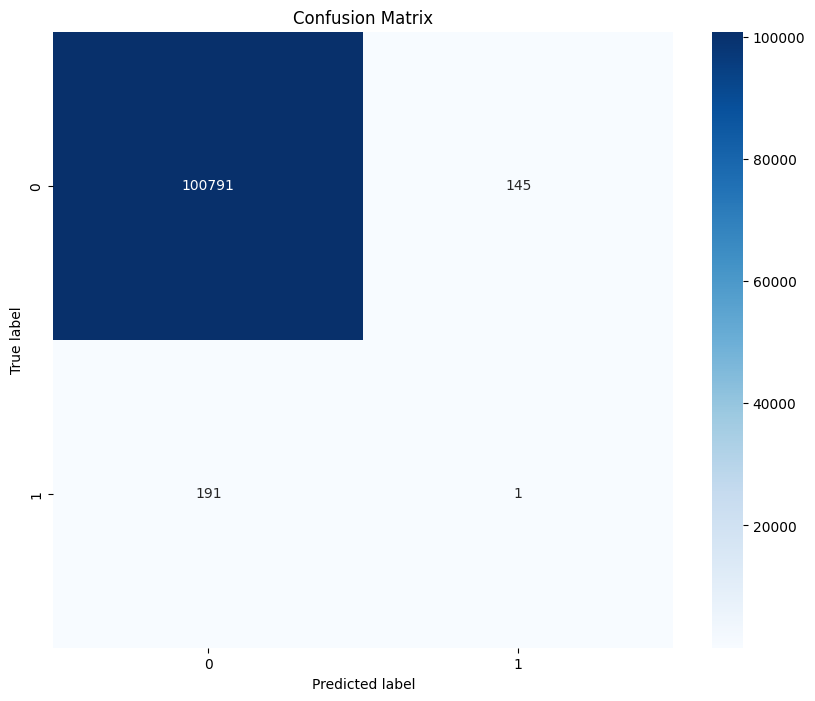

In [112]:
cm = confmat.compute().cpu().numpy()

plot_confusion_matrix(cm)

In [113]:
class_counts = df.head(50000)['is_fraud'].value_counts()
print(class_counts)

is_fraud
0    49899
1      101
Name: count, dtype: int64


In [23]:
filter = df[df['is_fraud'] == 1]
for row in filter['actions_str']:
    print(row)
    print()

profile and get customer response . campaign and get balance . tax free and get tax goal . calendar and audit search version 3 . peer registration and ask member . corporate management and clone user . corporate management and clone user . templates and meta . accounts and statements . transactions and series and post . accounts and beneficiaries . loans and list . corporate management and clone user . templates and meta . profile and user profile . wealth and party id . time deposits and detailed accounts . authentication and fast login . accounts and accounts full . donations and get donations list . corporate management and clone user . campaign and get campaigns . transactions and series and post . loans and list . campaign and get balance . tax free and get tax goal . accounts and statements pay from enriched . campaign and get campaigns . bill payments and pay . transactions and series and post . transactions and series and post . profile and get customer response . accounts and 

In [24]:
model.eval()

# List of texts to predict
texts = [
    "profile and get customer response . api and accounts and generic transfer ."
]

# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

# Move tensors to the same device as the model
input_ids = encodings['input_ids'].to(model.device)
attention_mask = encodings['attention_mask'].to(model.device)

# Get predictions
with torch.no_grad():
    logits = model(input_ids, attention_mask)
    predictions = torch.argmax(logits, dim=1)

# Convert predictions to CPU and then to a list
predictions = predictions.cpu().tolist()

In [25]:
label_map = {
    0: "no fraud",
    1: "fraud"
}

for text, pred in zip(texts, predictions):
    print(f"Text: {text}")
    print(f"Prediction: {label_map[pred]}")
    print("-" * 50)

Text: profile and get customer response . api and accounts and generic transfer .
Prediction: no fraud
--------------------------------------------------
